# Notebook for generating state

In [245]:
from numpy.typing import NDArray

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt


## Theoretical background

**Goal:** Generate CV states and Corresponding Wigner function for use in  marginal probability distribution $P(X_\theta)$ in phase-space.

By simulating the data, we can check for the exact solution after of the state reconstruction.

Overall workflow:
- Using `qutip` we can easily generate an arbitrary continous-variable (CV) state for use as the groundtruth
- Create Wigner function for groundtruth
- Compute marginal probability of wigner function for a range of $P(X_\theta)$ (Jonas suggested $\Delta\theta = \frac{\pi}{3}$, meaning we measure $\theta = \left[0, \frac{\pi}{3}, \frac{2\pi}{3}, \pi, \frac{4\pi}{3}, \frac{5\pi}{3}\right]$)
- Use the marginal probability distribution for reconstruction of state
- Measure in $X, Y, Z$ (?) on some statistical relevant number of states to get tomography and try to recreate groundtruth


In [295]:

def generate_cv_state(state_type : str ="vacuum", N : int=30, **kwargs):
    """Generate a continuous variable quantum state.

    This function can create different types of continuous variable states,
    including vacuum, coherent, and squeezed states (more to be included)
    
    Parameters
    ---
    state_type : str
        The type of state to generate. Options are "vacuum", "coherent", and "squeezed".
    N : int
        The dimension of the Hilbert space.
    **kwargs : dict
        Additional parameters for specific state types.
    """
    if state_type == "vacuum":
        return qt.basis(N, 0)
    
    elif state_type == "coherent":
        kwargs.setdefault("alpha", 0.0 + 0j)  # Default value for alpha in case it is not applied
        kwargs.pop("parity", None)  # Remove parity from kwargs to avoid passing it to qt.coherent
        return qt.coherent(N, **kwargs)
    
    elif state_type == "squeezed":
        r = kwargs.get("r", 0.5)
        return qt.squeeze(N, r, **kwargs)
    elif state_type == "cat":
        # Generate a cat state using coherent states
        alpha = kwargs.get("alpha", 2.0)
        parity = kwargs.get("parity", "even")
        return cat_state(N, alpha=alpha, parity=parity)

    else:
        raise ValueError(f"Unknown state type: {state_type}")


def cat_state(N, alpha=2.0, parity="even"):
    coh_p = generate_cv_state("coherent", N, alpha=alpha)
    coh_m = generate_cv_state("coherent", N, alpha=-alpha)

    if parity == "even":
        return (coh_p + coh_m).unit()
    elif parity == "odd":
        return (coh_p - coh_m).unit()
    else:
        raise ValueError(f"Unknown parity: {parity}")

    
def rotate_state(rho, theta):
    rho = rho if rho.isoper else qt.ket2dm(rho)
    N = rho.shape[0]
    a = qt.destroy(N)
    U = (1j*theta * a.dag() * a).expm()
    return U * rho * U.dag()

state = generate_cv_state("coherent", 3, alpha=2 - 2j)

In [322]:
def wigner_grid(rho : qt.Qobj | NDArray[np.float64], xmax : float | int=5., pmax : float | int=5., n : int=201):
    x = np.linspace(-xmax, xmax, n)
    p = np.linspace(-pmax, pmax, n)
    Xgrid, Pgrid = np.meshgrid(x, p)
    
    W = qt.wigner(rho, x, p, 
                #   method="laguerre",
                  
                  )

    return x, p, W
# X, P, W = wigner_grid(state)
# X.shape, P.shape, W.shape

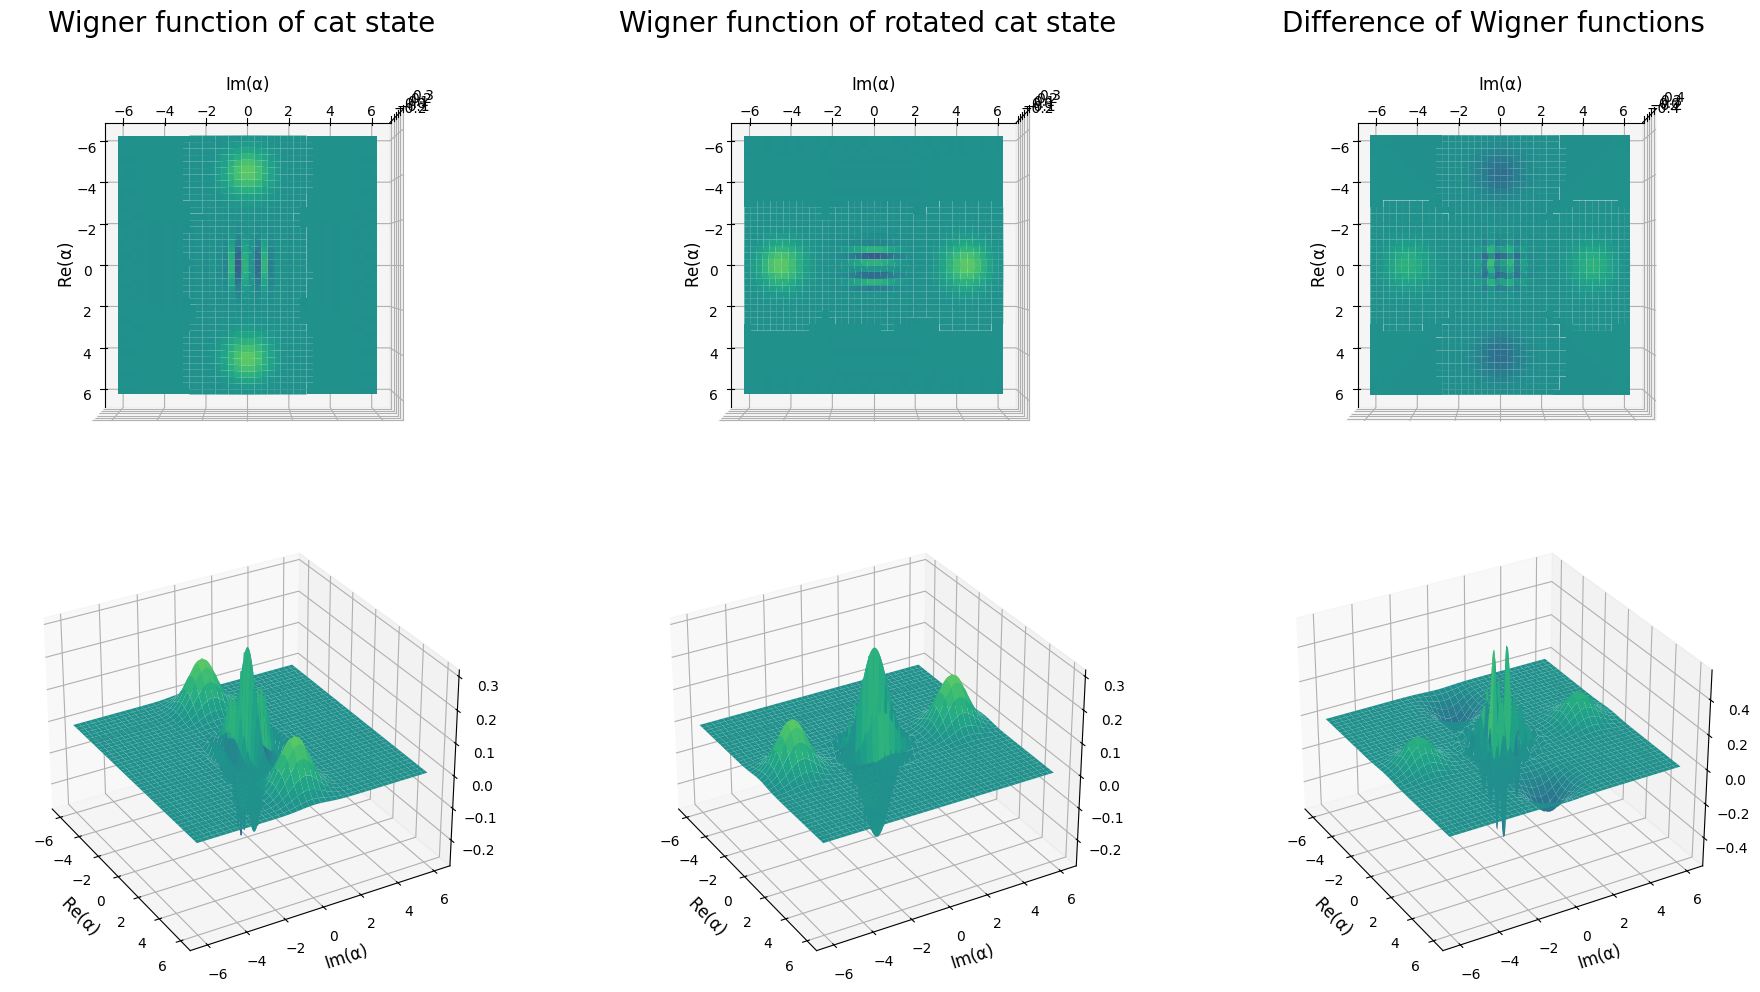

In [350]:
# plotting to ensure correct wigner function (takes ~40s to plot)
N = 200
alpha = 3 + 0.j # displacement
parity = "even" # parity for cat state
state_type = "cat" # state
test = generate_cv_state(state_type, 50, alpha=alpha, parity=parity) 
test_rot = rotate_state(test, np.pi/2)
x = np.linspace(-6, 6, N)
p = np.linspace(-6, 6, N)

fig, ax = plt.subplots(2, 3, figsize=(20, 10), 
                       subplot_kw={"projection": "3d"}
                       )
qt.plot_wigner(test, x, p, 
               cmap="viridis", fig=fig, ax=ax[0, 0], colorbar=False, projection="3d", method="laguerre")
qt.plot_wigner(test_rot, x, p, 
               cmap="viridis", fig=fig, ax=ax[0, 1], colorbar=False, projection="3d", method="laguerre")
qt.plot_wigner(test_rot - test.proj(), x, p, 
               cmap="viridis", fig=fig, ax=ax[0, 2], colorbar=False, projection="3d", method="laguerre")
qt.plot_wigner(test, x, p, 
               cmap="viridis", fig=fig, ax=ax[1, 0], colorbar=False, projection="3d", method="laguerre")
qt.plot_wigner(test_rot, x, p, 
               cmap="viridis", fig=fig, ax=ax[1, 1], colorbar=False, projection="3d", method="laguerre")
qt.plot_wigner(test_rot - test.proj(), x, p, 
               cmap="viridis", fig=fig, ax=ax[1, 2], colorbar=False, projection="3d", method="laguerre")


ax[0, 0].set_title("Wigner function of cat state", fontsize=20)
ax[0, 1].set_title("Wigner function of rotated cat state", fontsize=20)
ax[0, 2].set_title("Difference of Wigner functions", fontsize=20)

# add a single colorbar between the first and second row of 3D plots
# fig.colorbar(ax[0, :].collections[0], ax=ax[0, 0], orientation='vertical')
for a in ax[0, :]:
   a.view_init(elev=90, azim=0)

for a in ax[1, :]:
   a.view_init(elev=30, azim=-30)
   
fig.tight_layout()

## Computing marginal distributions


In [344]:
def marginal_from_wigner(W, p, axis="x"):
    """
    Compute a marginal by integrating the Wigner function along one axis.
    axis='p' gives ∫ W(x,p) dp -> P(x); axis='x' gives ∫ W(x,p) dx -> P(p).
    """
    if axis == "x":
        dx = p[1] - p[0]  # reuse grid spacing argument if needed
        P = np.trapezoid(W, axis=1, dx=dx)   # integrate over x
    elif axis == "p":
        dp = p[1] - p[0]
        P = np.trapezoid(W, axis=0, dx=dp)   # integrate over p
    else:
        raise ValueError("axis must be 'p' or 'x'")
    return P


thetas = [np.pi/3 * i for i in range(6)]
marginals = {}
for i in range(6):
    rot = rotate_state(test, np.pi/3*i)
    x, p, W = wigner_grid(rot)
    PX1 = marginal_from_wigner(W, p, axis="p")
    marginals[i] = PX1
marginals["X"] = x

marginals.keys()

dict_keys([0, 1, 2, 3, 4, 5, 'X'])

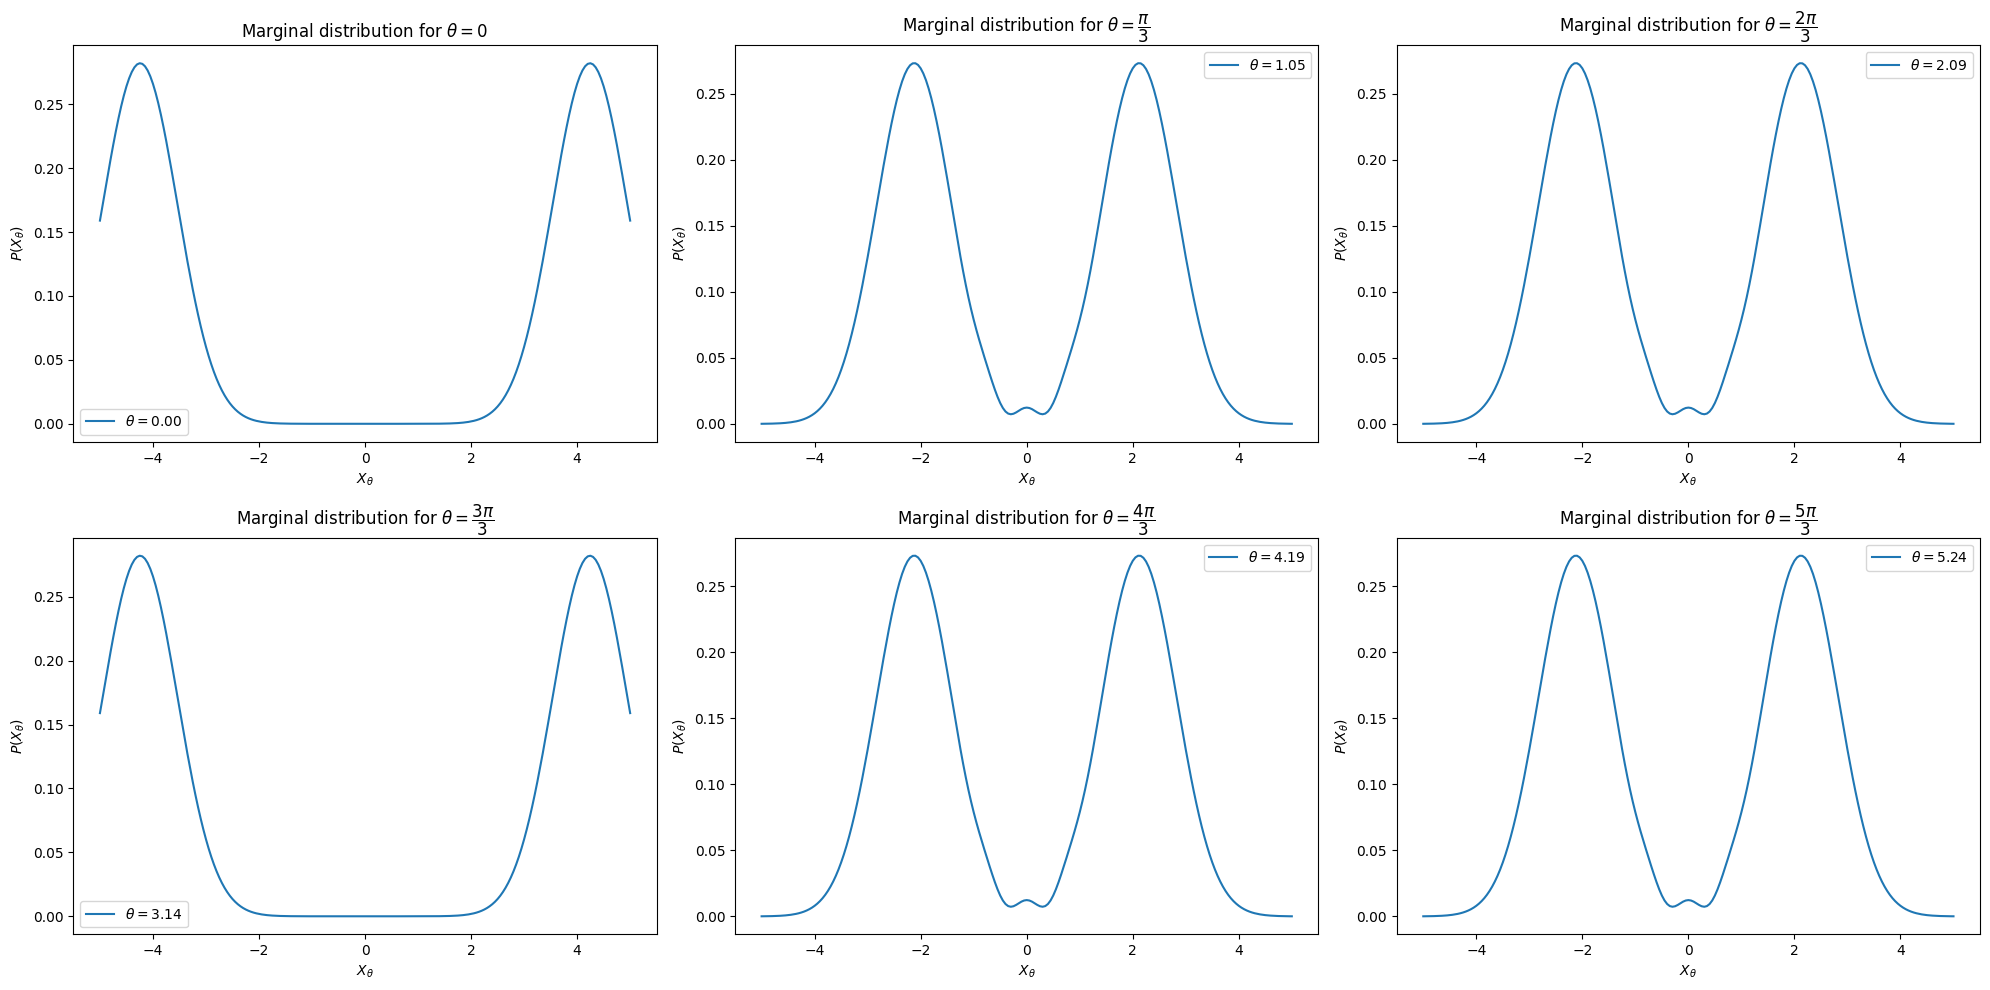

In [349]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
labs = [r"$0$", r"$\dfrac{\pi}{3}$"] + [rf"$\dfrac{{{i}\pi}}{{3}}$" for i in range(2, 6)]
for i in range(6):
    ax[i//3, i%3].plot(marginals["X"], marginals[i], label=f"$\\theta={np.pi/3*i:.2f}$")
    ax[i//3, i%3].set_title(f"Marginal distribution for $\\theta=${labs[i]}")
    ax[i//3, i%3].set_xlabel(r"$X_{\theta}$")
    ax[i//3, i%3].set_ylabel(r"$P(X_{\theta})$")
    ax[i//3, i%3].legend()
    
fig.tight_layout()